<a href="https://colab.research.google.com/github/brunotagoncalves/publicdataml/blob/main/Modelagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3.	Modelagem

In [1]:
!pip install catboost

     |████████████████████████████████| 65.8MB 57kB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from catboost import Pool, CatBoostRegressor

In [5]:
pd_df = pd.read_csv('drive/MyDrive/publicdataml/sample_data_featured_v1.csv',dtype='object',index_col=0)
cat_cols = pd_df.columns[pd_df.columns.str.contains('Descrição|dig')].tolist()
int_cols = pd_df.columns[pd_df.columns.str.contains('idade|pop_')].tolist()
target_cols = pd_df.columns[pd_df.columns.str.contains('salário|valor')].tolist()
key_cols = pd_df.columns[pd_df.columns.str.contains('faixapnad')].tolist()

In [7]:
for i in int_cols+target_cols:
  pd_df.loc[:,i] = pd_df.loc[:,i].astype('float')


In [8]:
pd_df = pd_df.loc[~pd_df.isnull().any(axis=1),:]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pd_df.loc[:,cat_cols+int_cols+key_cols], pd_df.loc[:,'salário'],random_state=123,test_size=.25)

In [10]:
idx_cat = [X_train.columns.get_loc(i) for i in cat_cols]

In [11]:
# initialize Pool
train_pool = Pool(X_train[cat_cols+int_cols], 
                  y_train, 
                  cat_features=idx_cat)

test_pool = Pool(X_test[cat_cols+int_cols], 
                 y_test, 
                 cat_features=idx_cat) 


In [ ]:
# specify the training parameters 
model1 = CatBoostRegressor(loss_function='MAE',eval_metric='MAPE',iterations=3000)
#train the model
model1.fit(train_pool,eval_set=test_pool)
model1.save_model('drive/MyDrive/publicdataml/ensemble_model_75.sav')

In [12]:
# make the prediction using the resulting model
model1 = CatBoostRegressor()
model1.load_model('drive/MyDrive/publicdataml/ensemble_model_75.sav')



In [13]:
preds = model1.predict(test_pool)
#print(preds)

In [14]:
pd_df_test = pd.concat([X_test,y_test],axis=1)

pd_df_test.loc[:,'preds'] = preds

In [15]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    mean_absolute_percentage_error=np.mean(np.abs(y_test-preds)/y_test)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MAPE: ', round(mean_absolute_percentage_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [16]:
regression_results(y_test,preds)

explained_variance:  0.4688
mean_squared_log_error:  0.155
r2:  0.463
MAE:  633.3031
MAPE:  0.2754
MSE:  4078608.3396
RMSE:  2019.5565


In [17]:
pd_df_test.loc[:,'AE'] = np.abs(pd_df_test.loc[:,'salário'] - pd_df_test.loc[:,'preds'])
pd_df_test.loc[:,'APE'] = pd_df_test.loc[:,'AE']/pd_df_test.loc[:,'salário']

In [18]:
pd_df_test.loc[:,['salário','preds']].corr('pearson')**2

,salário,preds
salário,1.00000,0.48431
preds,0.48431,1.00000


In [19]:
pd_df_test.groupby('faixapnad')['APE'].describe()

,count,mean,std,min,25%,50%,75%,max
faixapnad,,,,,,,,
1º Quintil PNAD,12678.0,0.482780,0.833317,0.000004,0.035628,0.122354,0.736241,17.346139
2º Quintil PNAD,12295.0,0.189937,0.419642,0.000003,0.016700,0.056153,0.208745,7.422713
3º Quintil PNAD,12461.0,0.159168,0.281458,0.000005,0.039601,0.087915,0.175868,5.047217
4º Quintil PNAD,12627.0,0.222545,0.309344,0.000049,0.059138,0.141948,0.275406,4.564064
5º Quintil PNAD,12512.0,0.318467,0.241230,0.000009,0.127568,0.280030,0.461235,2.359266


In [20]:
pd_df_test.groupby('faixapnad')['AE'].describe()

,count,mean,std,min,25%,50%,75%,max
faixapnad,,,,,,,,
1º Quintil PNAD,12678.0,254.057604,427.207175,0.001892,19.037641,66.772861,409.822525,10407.683659
2º Quintil PNAD,12295.0,171.494777,365.919241,0.003278,17.104410,55.647996,192.518175,5901.748004
3º Quintil PNAD,12461.0,203.043639,359.777451,0.006716,48.952833,109.889616,227.032308,5952.326357
4º Quintil PNAD,12627.0,424.116867,593.098231,0.073862,104.997217,257.721191,518.526362,8334.814371
5º Quintil PNAD,12512.0,2110.993589,3850.315852,0.035512,501.969948,1127.227178,2199.353594,48291.209622


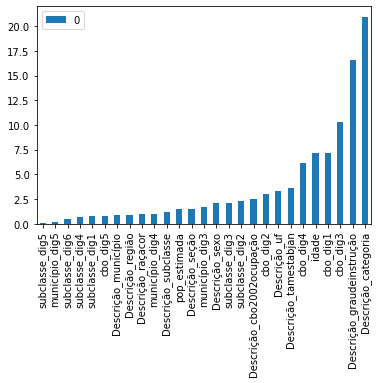

In [137]:
pd.DataFrame(model1.feature_importances_,index=cat_cols+int_cols).sort_values(0).plot.bar()

In [35]:
import pandas as pd
#imp = pd.DataFrame(model1.feature_importances_,index=cat_cols+int_cols).sort_values(0).cumsum()[0]
#best_cols= imp[imp>5].index.tolist()
idx_cat = [X_train[cat_cols+int_cols].columns.get_loc(i) for i in cat_cols]

In [36]:
# initialize Pool
train_pool = Pool(X_train[cat_cols+int_cols], 
                  y_train, 
                  cat_features=idx_cat)

test_pool = Pool(X_test[cat_cols+int_cols], 
                 y_test, 
                 cat_features=idx_cat) 


In [37]:
from sklearn.preprocessing import OneHotEncoder


In [38]:
OHE = OneHotEncoder(handle_unknown='ignore')

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [40]:
ct  = ColumnTransformer([('pp',Pipeline([
        ("OHE", OHE),('imp',SimpleImputer(strategy='most_frequent'))]),cat_cols),('imp',SimpleImputer(strategy='most_frequent'),int_cols)])

In [41]:
X_train_catcols = ct.fit_transform(X_train)
X_test_catcols = ct.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1,solver='adam', verbose=True).fit(X_train_catcols, y_train)


Iteration 1, loss = 8072213.90598921
Iteration 2, loss = 5324559.91893640
Iteration 3, loss = 5691352.89652525


In [ ]:

from joblib import dump, load
dump(regr,'drive/MyDrive/publicdataml/mlp_model.joblib')
regr = load('drive/MyDrive/publicdataml/mlp_model.joblib')



In [ ]:
preds = regr.predict(X_test_catcols)

In [ ]:
pd_df_test.loc[:,'preds_mlp'] = preds

In [ ]:
pd_df_test.loc[:,['salário','preds','preds_mlp']].corr()

In [ ]:
regression_results(y_test,preds)

In [ ]:
pd_df_test.loc[:,'AE_MLP'] = np.abs(pd_df_test.loc[:,'salário'] - pd_df_test.loc[:,'preds_mlp'])
pd_df_test.loc[:,'APE_MLP'] = pd_df_test.loc[:,'AE_MLP']/pd_df_test.loc[:,'salário']

In [ ]:
pd_df_test.groupby('faixapnad')['APE_MLP'].describe()

In [ ]:
pd_df_test.groupby('faixapnad')['AE_MLP'].describe()

In [46]:
pd_df_test.to_csv('drive/MyDrive/publicdataml/test_results.csv')

|Exemplos:| Sr. 98 | Monica | Ana |
|---|---|---|---|
|**Idade:**| 26  | 54  | 45  |
|**Munícipio:**|  Porto Alegre | São Paulo  | Fortaleza  |
|**Profissão:**| Humorista / Radialista  | Enfermeira | Diretora Comercial  |
|**Porte da Empresa:**| Mais de 1000 colaboradores  | Mais de 1000 colaboradores  | Entre 20 e 50 Colaboradores |
|**Grau de Instrução** | Ensino Médio Completo | Ensino Superior Completo | Pós-Graduação Completa



In [17]:
(model1.predict([
               'Sul'              
,'Rio Grande do Sul'
,'Rs-Porto Alegre'
,'Informação e Comunicação '
,'Atividades de Rádio'
,'Empregado - Geral, inclusive o empregado público da administração direta ou indireta contratado pela CLT'
,'Comentarista de Radio e Televisao'
,'Médio Completo'
,'Homem'
,'Preta'
,'1000 ou mais vínculos'
,'6'
,'60'
,'601'
,'6010'
,'60101'
,'601010'
,'2'
,'26'
,'261'
,'2617'
,'26171'
,'431'
,'4314'
,'43149'
,26
,1488252.0
])*3).round(-1)

6680.0

In [18]:
(model1.predict(['Sudeste'
,'São Paulo'
,'Sp-Sao Paulo'
,'Saúde Humana e Serviços Sociais'
,'Atividades de Atendimento Hospitalar, Exceto Pronto-Socorro e Unidades para Atendimento a Urgências'
,'Empregado - Geral, inclusive o empregado público da administração direta ou indireta contratado pela CLT'
,'Enfermeiro de Terapia Intensiva'
,'Superior Completo'
,'Mulher'
,'Preta'
,'1000 ou mais vínculos'
,'8'
,'86'
,'861'
,'8610'
,'86101'
,'861010'
,'2'
,'22'
,'223'
,'2235'
,'22352'
,'355'
,'3550'
,'35503'
,54
,12325200
])).round(-1)

5260.0

In [20]:
(model1.predict([ 'Nordeste'
,'Ceará'
,'Ce-Fortaleza'
,'Comércio, Reparação de Veículos Automotores e Motocicletas'
,'Comércio Varejista de Móveis'
,'Empregado - Geral, inclusive o empregado público da administração direta ou indireta contratado pela CLT'
,'Diretor Comercial'
,'Pós-Graduação completa'
,'Mulher'
,'Parda'
,'De 20 a 49 vínculos'
,'4'
,'47'
,'475'
,'4754'
,'47547'
,'475470'
,'1'
,'12'
,'123'
,'1233'
,'12330'
,'230'
,'2304'
,'23044'
,45
,2686610

])*3).round(-1)

19370.0

In [21]:
pd_df.loc[:,'preds'] = model1.predict(pd_df.loc[:,cat_cols+int_cols])

In [22]:
pd_df.sort_values('preds',ascending=False).head(20)

,Descrição_região,Descrição_uf,Descrição_município,Descrição_seção,Descrição_subclasse,Descrição_categoria,Descrição_cbo2002ocupação,Descrição_graudeinstrução,Descrição_sexo,Descrição_raçacor,Descrição_tamestabjan,subclasse_dig1,subclasse_dig2,subclasse_dig3,subclasse_dig4,subclasse_dig5,subclasse_dig6,cbo_dig1,cbo_dig2,cbo_dig3,cbo_dig4,cbo_dig5,município_dig3,município_dig4,município_dig5,idade,pop_estimada,faixapnad,salário,valorhora,preds
16383,Sudeste,São Paulo,Sp-Sao Paulo,"Atividades Financeiras, de Seguros e Serviços ...","Bancos Múltiplos, com Carteira Comercial","Empregado - Geral, inclusive o empregado públi...",Diretor Administrativo e Financeiro,Mestrado,Homem,Branca,1000 ou mais vínculos,6,64,642,6422,64221,642210,1,12,123,1231,12311,355,3550,35503,50.0,12325232.0,5º Quintil PNAD,40646.18,1016.154500,17306.630249
43802,Sudeste,Rio de Janeiro,Rj-Rio de Janeiro,"Atividades Financeiras, de Seguros e Serviços ...",Planos de Saúde,"Empregado - Geral, inclusive o empregado públi...",Diretor de Servicos de Saude,Pós-Graduação completa,Homem,Branca,De 500 a 999 vínculos,6,65,655,6550,65502,655020,1,13,131,1312,13120,330,3304,33045,65.0,6747815.0,5º Quintil PNAD,31404.00,897.257143,16365.099266
3596,Sudeste,São Paulo,Sp-Sao Paulo,"Atividades Financeiras, de Seguros e Serviços ...",Seguros de Vida,"Empregado - Geral, inclusive o empregado públi...",Diretor de Produtos Bancarios,Pós-Graduação completa,Homem,Amarela,De 100 a 249 vínculos,6,65,651,6511,65111,651110,1,12,122,1227,12271,355,3550,35503,46.0,12325232.0,5º Quintil PNAD,25000.00,568.181818,15815.841327
7647,Sudeste,São Paulo,Sp-Sao Paulo,"Atividades Financeiras, de Seguros e Serviços ...","Bancos Múltiplos, sem Carteira Comercial","Empregado - Geral, inclusive o empregado públi...",Diretor de Riscos de Mercado,Pós-Graduação completa,Homem,Branca,De 500 a 999 vínculos,6,64,643,6431,64310,643100,1,12,122,1227,12275,355,3550,35503,40.0,12325232.0,5º Quintil PNAD,42651.46,969.351364,15680.682454
1511,Sudeste,São Paulo,Sp-Sao Paulo,Indústrias de Transformação,Fabricação de Aditivos de Uso Industrial,"Empregado - Geral, inclusive o empregado públi...",Gerente de Vendas,Mestrado,Homem,Branca,De 100 a 249 vínculos,2,20,209,2093,20932,209320,1,14,142,1423,14232,355,3550,35503,56.0,12325232.0,5º Quintil PNAD,11063.84,251.450909,15609.215938
10806,Sudeste,São Paulo,Sp-Sao Paulo,Outras Atividades de Serviços,Atividades de Organizações Associativas Patron...,"Empregado - Geral, inclusive o empregado públi...",Diretor Administrativo,Mestrado,Homem,Branca,De 20 a 49 vínculos,9,94,941,9411,94111,941110,1,12,123,1231,12310,355,3550,35503,63.0,12325232.0,5º Quintil PNAD,34411.00,860.275000,15431.129972
35329,Sudeste,São Paulo,Sp-Sorocaba,Indústrias de Transformação,Fabricação de Baterias e Acumuladores para Veí...,"Empregado - Geral, inclusive o empregado públi...",Gerente de Projetos e Servicos de Manutencao,Pós-Graduação completa,Homem,Branca,1000 ou mais vínculos,2,27,272,2722,27228,272280,1,14,142,1427,14270,355,3552,35522,57.0,687357.0,5º Quintil PNAD,12285.21,279.209318,15096.816898
5462,Sudeste,São Paulo,Sp-Sao Paulo,"Atividades Financeiras, de Seguros e Serviços ...",Planos de Saúde,"Empregado - Geral, inclusive o empregado públi...",Diretor de Recursos Humanos,Pós-Graduação completa,Mulher,Branca,De 50 a 99 vínculos,6,65,655,6550,65502,655020,1,12,123,1232,12320,355,3550,35503,42.0,12325232.0,5º Quintil PNAD,43000.00,1075.000000,15088.544984
16562,Sudeste,São Paulo,Sp-Sao Paulo,Informação e Comunicação,Desenvolvimento e Licenciamento de Programas d...,"Empregado - Geral, inclusive o empregado públi...",Gerente de Pesquisa e Desenvolvimento (P&D),Pós-Graduação completa,Homem,Branca,1000 ou mais vínculos,6,62,620,6203,62031,620310,1,14,142,1426,14260,355,3550,35503,54.0,12325232.0,5º Quintil PNAD,18500.00,420.454545,14979.245898
16382,Sudeste,São Paulo,Sp-Sao Paulo,"Atividades Profissionais, Científicas e Técnicas",Atividades de Consultoria em Gestão Empresaria...,"Empregado 

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


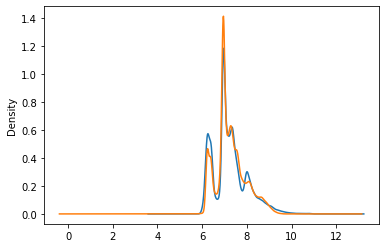

In [23]:
np.log1p(pd_df.loc[:,'salário']).plot.density()
np.log1p(pd_df.loc[:,'preds']).plot.density()
